### 1. Prowizje

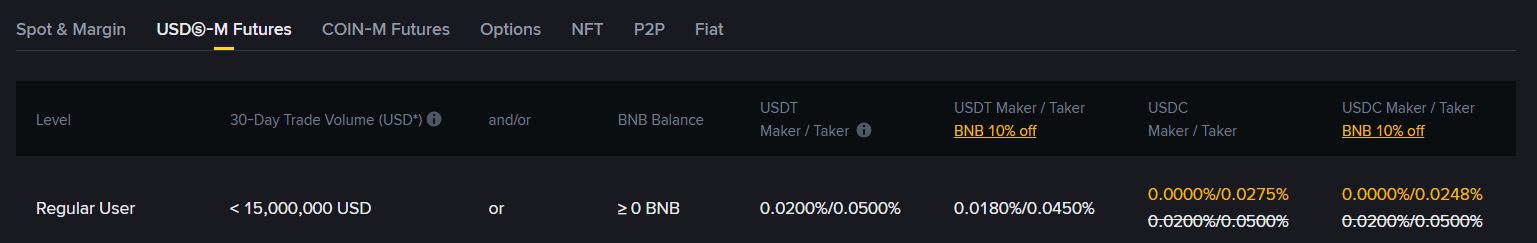
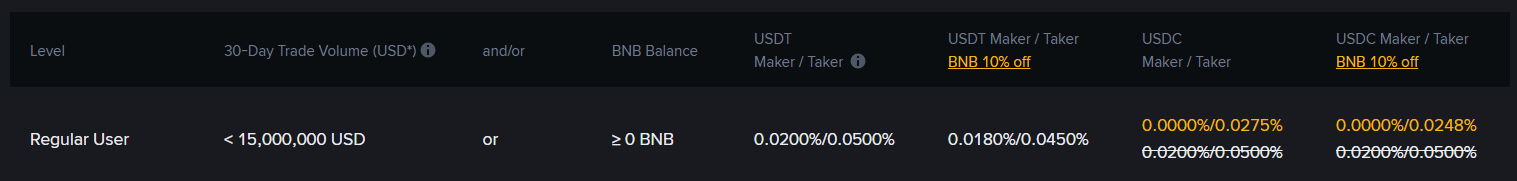

Rozpatrujemy najbardziej pesymistyczną opcję: otwieramy pozycje market, czyli za pozycję płacimy 0.05% prowizji (Taker - liquidity, zabieramy płynność otwierając pozycję po cenie market). Prowizję można zminimalizować płacąc w BNB lub handlując w USDC a nie USDT, ale my robimy opcję negatywną. Dodatkowo do prowizji dodamy też procentowy średni spread na parze (wyliczony w tabeli). Prowizja jest płacona przy otwarciu i zamknięciu pozycji, czyli czterokrotnie (otwarcie long x short y, zamknięcie ...).

https://www.binance.com/en/fee/futureFee

### 2. Spread
Będzie tabela średniego spreadu z okresu analizy dla każdego aktywa wliczana podobnie jak prowizje.

### 3. Wielkość kapitału

Nie reinwestujemy. Wielkość dostępnego kapitału dla pozycji jest zawsze taka sama, ustalona na initial_cash. "Na boku" obliczamy skumulowane zysk/stratę/prowizje i jeśli przekroczą one initial_cash to kończymy handel. Nie chcemy, aby mniejszy dostępny kapitał po początkowych stratach zaburzał nam dalszy handel. Interesuje nas stricte skuteczność zawierania pozycji w okresie handlowym. W praktyce wyglądałoby to tak, że handlując initial_cash = 100 000 w portfelu znajdowałoby się 200 000: 100 000 jako kapitał przeznaczony na otwieranie pozycji (który nie będzie się zmniejszać pod wpływem strat/kosztów) oraz 100 000 jako kapitał na potencjalne straty/koszty (czyli możemy stracić maksymalnie 100% initial_cash). Nasz system nie ma na celu optymalizację zarządzania ryzykiem/performance w portfelu - on ma na celu dobre handlowanie pair tradingiem. Ma mieć środowisko do niezależnych decyzji tradingowych, pierwsze straty spowodowane rynkiem nie mogą wpłynąć na to że później będzie podejmować gorsze decyzje przez mniejszy kapitał. Chcemy, aby skupił się na niezależnych decyzjach tradingowych opartych na statystyce, a nie na zarządzaniu portfelem.

### 4. Optymalizacja hiperparametrów

Hiperparametry takie jak entry/exit thresholds, czy rolling_window (dla liczenia z-score) w strategii statycznej (bez RL) optymalizujemy za pomocą metody Bayesian Optimization, gdyż ma ona wiele przewag nad metodami takimi jak Grid Search, czy Random Search.

[jakie przewagi?]

### 4. Najważniejsze wskaźniki do optymalizacji hiperparametrów

Optymalizując hiperparametry (thresholds i rolling_window) musimy odpowiedzieć na pytanie, co jest naszym wyznacznikiem dobrych parametrów. Do tego zadania potrzebujemy wybrać najważniejsze wskaźniki świadczące o jakości tych hiperparametrów.

Yang&Malik: maksymalizowali RTOT (wiele wad)

Propozycja (od najważniejszych do mniej ważnych): sqn>sortino>k-ratio>calmar>sharpe

Dodatkowo trzeba wybrać metodę optymalizacji hiperparametrów. Bayesian Optimization ma wiele zalet w porównaniu do Grid Search/Random Search.